Roll Number: 102303365
Calculated Constants: a_r = 0.15, b_r = 0.3
Detected 'data_ass.csv' as a ZIP archive. Attempting to extract 'data.csv'.
Successfully extracted 'data.csv' from 'data_ass.csv'.
Successfully loaded 419509 data points.

LEARNED PARAMETERS FOR SUBMISSION
Lambda (λ): 0.00348087
Mu (μ):     19.90373656
c:          0.03193281


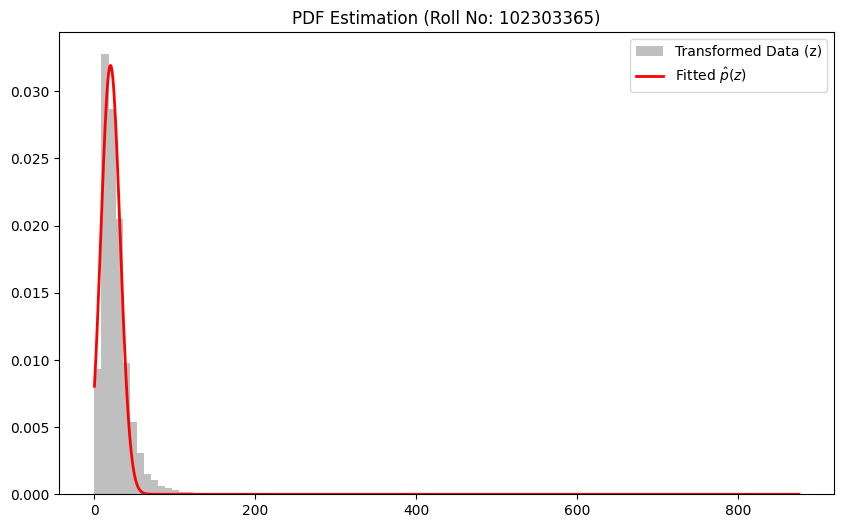

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import zipfile # Added for handling zip files
import os      # Added for file operations

# ==========================================
# CONFIGURATION
# ==========================================
ROLL_NUMBER = 102303365
FILENAME = 'data_ass.csv'

ar = 0.15
br = 0.3

print(f"Roll Number: {ROLL_NUMBER}")
print(f"Calculated Constants: a_r = {ar}, b_r = {br}")

# ==========================================
# DATA LOADING & PREPROCESSING
# ==========================================
try:
    actual_data_filename = None

    # Check if the FILENAME is a zip file
    if zipfile.is_zipfile(FILENAME):
        print(f"Detected '{FILENAME}' as a ZIP archive. Attempting to extract 'data.csv'.")
        with zipfile.ZipFile(FILENAME, 'r') as zip_ref:
            zip_contents = zip_ref.namelist()
            if 'data.csv' in zip_contents:
                zip_ref.extract('data.csv', path='.') # Extract to current directory
                actual_data_filename = 'data.csv'
                print(f"Successfully extracted '{actual_data_filename}' from '{FILENAME}'.")
            else:
                print(f"Error: 'data.csv' not found inside '{FILENAME}'. Available files: {zip_contents}")
                raise ValueError(f"Required 'data.csv' not found inside '{FILENAME}'.")
    else:
        # If not a zip file, assume it's the CSV directly
        actual_data_filename = FILENAME

    # Ensure actual_data_filename is set
    if not actual_data_filename:
        raise FileNotFoundError(f"Could not determine the actual data file to load from {FILENAME}.")

    # Now read the actual data file (either original CSV or extracted CSV)
    # ADDED: on_bad_lines='skip' to handle the formatting error in your CSV
    # ADDED: engine='python' for robustness against malformed lines
    df = pd.read_csv(actual_data_filename,
                     encoding='ISO-8859-1',
                     on_bad_lines='skip',
                     engine='python')

    # Identify the NO2 column
    col_name = None
    for c in df.columns:
        if 'no2' in c.lower():
            col_name = c
            break

    if col_name:
        x = pd.to_numeric(df[col_name], errors='coerce').dropna().values
        print(f"Successfully loaded {len(x)} data points.")
    else:
        print("Error: Could not find an NO2 column in the CSV.")
        print(f"Available columns: {df.columns.tolist()}") # Added for debugging
        raise ValueError("Required 'NO2' column not found in the CSV.")

except FileNotFoundError:
    print(f"Error: The file '{FILENAME}' or the extracted data file was not found.")
    raise FileNotFoundError(f"Error: The file '{FILENAME}' or the extracted data file was not found.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    raise RuntimeError(f"An error occurred during data loading: {e}")


# ==========================================
# STEP 1: TRANSFORMATION
# ==========================================
z = x + ar * np.sin(br * x)

# ==========================================
# STEP 2: LEARN PARAMETERS (λ, μ, c)
# ==========================================
counts, bin_edges = np.histogram(z, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def pdf_model(z_val, lmbda, mu, c):
    return c * np.exp(-lmbda * (z_val - mu)**2)

# Initial Guess [lambda, mu, c]
initial_guess = [0.001, np.mean(z), np.max(counts)]

try:
    popt, _ = curve_fit(pdf_model, bin_centers, counts, p0=initial_guess)
    lmbda_opt, mu_opt, c_opt = popt

    print("\n" + "="*30)
    print("LEARNED PARAMETERS FOR SUBMISSION")
    print("="*30)
    print(f"Lambda (λ): {lmbda_opt:.8f}")
    print(f"Mu (μ):     {mu_opt:.8f}")
    print(f"c:          {c_opt:.8f}")
    print("="*30)

except Exception as e:
    print(f"Curve fitting failed: {e}")
    raise RuntimeError(f"Curve fitting failed: {e}")

# ==========================================
# VISUALIZATION
# ==========================================
plt.figure(figsize=(10, 6))
plt.hist(z, bins=100, density=True, alpha=0.5, color='gray', label='Transformed Data (z)')
z_range = np.linspace(min(z), max(z), 1000)
plt.plot(z_range, pdf_model(z_range, *popt), color='red', lw=2, label=r'Fitted $\hat{p}(z)$')
plt.title(f"PDF Estimation (Roll No: {ROLL_NUMBER})")
plt.legend()
plt.show()